In [2]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
import pickle
BASE_PATH = "/kaggle/input/cifar-wec/cifar-10-batches-py"

train_data = []
train_label = []

def unpickle(file):
    with open(file ,'rb') as f:
        data_dict = pickle.load(f , encoding = 'bytes')
    return data_dict
        
for i in range(1,6):
    batch_path = os.path.join(BASE_PATH , f"data_batch_{i}" )
    batch = unpickle(batch_path)
    train_data.append(batch[b'data'])
    train_label.extend(batch[b'labels'])

X_train = np.vstack(train_data)      
y_train = np.array(train_label)     

In [4]:
test_data = []
test_label = []

test_path = os.path.join(BASE_PATH , 'test_batch')
test_batch = unpickle(test_path)
test_data.append(batch[b'data'])
test_label.extend(batch[b'labels'])

y_test = np.array(test_label)    

In [24]:
X_train.shape

(50000, 3072)

In [28]:
# I will calculate CIFAR MEAN AND CIFAR STD And use it as a normalizing technique for the 3 the channels of the RGB

X = X_train.astype('float32') / 255.0

X = X.reshape(-1, 3, 32, 32) # X_train shape is (50000, 3072) which is a flattened version 
X = np.transpose(X, (0, 2, 3, 1))#this changes the arrangement just like we have permute in torch
print(X.shape)
mean = X.mean(axis=(0, 1, 2))
std = X.std(axis=(0, 1, 2))

print("Mean:", mean)
print("Std:", std)   

(50000, 32, 32, 3)
Mean: [0.4914009  0.48215896 0.4465308 ]
Std: [0.24703279 0.24348423 0.26158753]


In [5]:
CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD  = (0.2470, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),         
    transforms.RandomHorizontalFlip(p=0.5),        
    transforms.ColorJitter(brightness=0.1, contrast=0.1,
                           saturation=0.1, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

In [6]:
def cifar_flat_to_pil(img_flat):
    r = img_flat[0:1024].reshape(32,32)
    g = img_flat[1024:2048].reshape(32,32)
    b = img_flat[2048:3072].reshape(32,32)
    img = np.stack([r,g,b], axis=2).astype('uint8')
    pil_img = Image.fromarray(img).convert("RGB")
    return pil_img

# Converting a Fla

In [7]:
from PIL import Image
def cifar_dataset_to_pil(flat_images):
    pil_images = []
    for img_flat in flat_images:
        pil_img = cifar_flat_to_pil(img_flat)  # pass the array directly
        pil_images.append(pil_img)
    return pil_images

train_data_flat = np.vstack(train_data)
test_data_flat = np.vstack(test_data)   

train_images = cifar_dataset_to_pil(train_data_flat)
test_images = cifar_dataset_to_pil(test_data_flat)

In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import multiprocessing

class CIFAR10_dataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.has_labels = labels is not None
        print(f"\nLoading CIFAR10 Dataset... Total Len: {len(images)} | Labeled: {self.has_labels}\n{'-'*50}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        if self.has_labels:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return {"img": img, "label": label}
        else:
            return {"img": img}


train_images_split, val_images, y_train_split, y_val = train_test_split(
    train_images, y_train,
    test_size=0.2,         
    random_state=42,       
    stratify=y_train        
)

In [9]:
train_dataset = CIFAR10_dataset(train_images_split, y_train_split, transform=train_transform)
val_dataset = CIFAR10_dataset(val_images, y_val, transform=test_transform)
test_dataset = CIFAR10_dataset(test_images, labels=None, transform=test_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=multiprocessing.cpu_count(),
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=multiprocessing.cpu_count(),
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=multiprocessing.cpu_count(),
    pin_memory=True,
    persistent_workers=True
)


Loading CIFAR10 Dataset... Total Len: 40000 | Labeled: True
--------------------------------------------------

Loading CIFAR10 Dataset... Total Len: 10000 | Labeled: True
--------------------------------------------------

Loading CIFAR10 Dataset... Total Len: 10000 | Labeled: False
--------------------------------------------------


In [10]:
from torch import nn

class AdvancedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(AdvancedCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32 * 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32 * 2, out_channels=64 * 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64 * 2, out_channels=64 * 2, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64 * 2, out_channels=128 * 2, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128 * 2, out_channels=128 * 2, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128 * 2, out_channels=128 * 2, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=128 * 2, out_channels=256 * 2, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(in_channels=256 * 2, out_channels=256 * 2, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=256 * 2, out_channels=256 * 2, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(32 * 2)
        self.bn2 = nn.BatchNorm2d(128 * 2)
        self.bn3 = nn.BatchNorm2d(256 * 2)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout2d(0.2)

        self.fc1 = nn.Linear(4096 * 2, 4096 * 2)
        self.fc2 = nn.Linear(4096 * 2, 2048 * 2)
        self.fc3 = nn.Linear(2048 * 2, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)

        x = self.relu(self.bn2(self.conv4(x)))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.maxpool(x)
        x = self.dropout(x)

        x = self.relu(self.bn3(self.conv7(x)))
        x = self.relu(self.conv8(x))
        x = self.relu(self.conv9(x))
        x = self.maxpool(x)
        x = self.dropout(x)

        x = torch.flatten(x, start_dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

#Initiating the Custom CNN Model
num_classes = 10
net = AdvancedCNN(num_classes)
print(net)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Params: ", count_parameters(net))

AdvancedCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
print("Model moved to:", device)

Model moved to: cuda


In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay=1e-6, momentum=0.9)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, min_lr=0.00001)
epochs = 50

Epoch 1/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 1/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 23.61it/s]



 Epoch 1 Results:
   Train Loss: 1.8761 | Train Acc: 28.41%
   Val Loss: 1.6596 | Val Acc: 38.46%
   Val Precision: 0.4260 | Recall: 0.3846 | F1: 0.3538
   LR: 0.010000
NEW BEST MODEL! Val Acc: 38.46%


Epoch 2/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 2/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.85it/s]



 Epoch 2 Results:
   Train Loss: 1.4607 | Train Acc: 45.91%
   Val Loss: 1.3753 | Val Acc: 52.22%
   Val Precision: 0.5484 | Recall: 0.5222 | F1: 0.5050
   LR: 0.010000
NEW BEST MODEL! Val Acc: 52.22%


Epoch 3/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 3/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.85it/s]



 Epoch 3 Results:
   Train Loss: 1.2284 | Train Acc: 55.19%
   Val Loss: 1.2304 | Val Acc: 57.00%
   Val Precision: 0.6268 | Recall: 0.5700 | F1: 0.5616
   LR: 0.010000
NEW BEST MODEL! Val Acc: 57.00%


Epoch 4/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 4/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.29it/s]



 Epoch 4 Results:
   Train Loss: 1.0821 | Train Acc: 60.84%
   Val Loss: 1.0623 | Val Acc: 63.57%
   Val Precision: 0.6917 | Recall: 0.6357 | F1: 0.6385
   LR: 0.010000
NEW BEST MODEL! Val Acc: 63.57%


Epoch 5/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 5/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.35it/s]



 Epoch 5 Results:
   Train Loss: 0.9734 | Train Acc: 65.61%
   Val Loss: 0.8326 | Val Acc: 70.09%
   Val Precision: 0.7229 | Recall: 0.7009 | F1: 0.6984
   LR: 0.010000
NEW BEST MODEL! Val Acc: 70.09%


Epoch 6/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 6/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.55it/s]



 Epoch 6 Results:
   Train Loss: 0.8869 | Train Acc: 68.83%
   Val Loss: 0.8720 | Val Acc: 70.29%
   Val Precision: 0.7399 | Recall: 0.7029 | F1: 0.7060
   LR: 0.010000
NEW BEST MODEL! Val Acc: 70.29%


Epoch 7/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 7/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.54it/s]



 Epoch 7 Results:
   Train Loss: 0.8137 | Train Acc: 71.30%
   Val Loss: 0.7047 | Val Acc: 74.87%
   Val Precision: 0.7759 | Recall: 0.7487 | F1: 0.7468
   LR: 0.010000
NEW BEST MODEL! Val Acc: 74.87%


Epoch 8/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 8/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.53it/s]



 Epoch 8 Results:
   Train Loss: 0.7560 | Train Acc: 73.41%
   Val Loss: 0.6564 | Val Acc: 77.32%
   Val Precision: 0.7725 | Recall: 0.7732 | F1: 0.7679
   LR: 0.010000
NEW BEST MODEL! Val Acc: 77.32%


Epoch 9/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 9/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.55it/s]



 Epoch 9 Results:
   Train Loss: 0.7084 | Train Acc: 75.33%
   Val Loss: 0.5761 | Val Acc: 80.24%
   Val Precision: 0.8102 | Recall: 0.8024 | F1: 0.8028
   LR: 0.010000
NEW BEST MODEL! Val Acc: 80.24%


Epoch 10/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 10/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.64it/s]



 Epoch 10 Results:
   Train Loss: 0.6621 | Train Acc: 77.02%
   Val Loss: 0.6005 | Val Acc: 79.30%
   Val Precision: 0.8037 | Recall: 0.7930 | F1: 0.7918
   LR: 0.010000


Epoch 11/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 11/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.61it/s]



 Epoch 11 Results:
   Train Loss: 0.6251 | Train Acc: 78.36%
   Val Loss: 0.5053 | Val Acc: 82.53%
   Val Precision: 0.8289 | Recall: 0.8253 | F1: 0.8251
   LR: 0.010000
NEW BEST MODEL! Val Acc: 82.53%


Epoch 12/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 12/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.51it/s]



 Epoch 12 Results:
   Train Loss: 0.5960 | Train Acc: 79.23%
   Val Loss: 0.5398 | Val Acc: 81.68%
   Val Precision: 0.8258 | Recall: 0.8168 | F1: 0.8165
   LR: 0.010000


Epoch 13/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 13/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.65it/s]



 Epoch 13 Results:
   Train Loss: 0.5731 | Train Acc: 79.98%
   Val Loss: 0.5009 | Val Acc: 82.47%
   Val Precision: 0.8399 | Recall: 0.8247 | F1: 0.8273
   LR: 0.010000


Epoch 14/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 14/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.70it/s]



 Epoch 14 Results:
   Train Loss: 0.5415 | Train Acc: 81.38%
   Val Loss: 0.4747 | Val Acc: 83.70%
   Val Precision: 0.8445 | Recall: 0.8370 | F1: 0.8366
   LR: 0.010000
NEW BEST MODEL! Val Acc: 83.70%


Epoch 15/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 15/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.48it/s]



 Epoch 15 Results:
   Train Loss: 0.5129 | Train Acc: 82.20%
   Val Loss: 0.4209 | Val Acc: 86.21%
   Val Precision: 0.8645 | Recall: 0.8621 | F1: 0.8621
   LR: 0.010000
NEW BEST MODEL! Val Acc: 86.21%


Epoch 16/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 16/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.66it/s]



 Epoch 16 Results:
   Train Loss: 0.4951 | Train Acc: 82.83%
   Val Loss: 0.4549 | Val Acc: 84.57%
   Val Precision: 0.8519 | Recall: 0.8457 | F1: 0.8458
   LR: 0.010000


Epoch 17/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 17/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.84it/s]



 Epoch 17 Results:
   Train Loss: 0.4680 | Train Acc: 83.89%
   Val Loss: 0.3972 | Val Acc: 86.51%
   Val Precision: 0.8671 | Recall: 0.8651 | F1: 0.8650
   LR: 0.010000
NEW BEST MODEL! Val Acc: 86.51%


Epoch 18/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 18/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.48it/s]



 Epoch 18 Results:
   Train Loss: 0.4572 | Train Acc: 84.33%
   Val Loss: 0.4006 | Val Acc: 86.39%
   Val Precision: 0.8670 | Recall: 0.8639 | F1: 0.8638
   LR: 0.010000


Epoch 19/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 19/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.59it/s]



 Epoch 19 Results:
   Train Loss: 0.4356 | Train Acc: 85.06%
   Val Loss: 0.4143 | Val Acc: 86.00%
   Val Precision: 0.8718 | Recall: 0.8600 | F1: 0.8608
   LR: 0.010000


Epoch 20/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 20/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.77it/s]



 Epoch 20 Results:
   Train Loss: 0.4182 | Train Acc: 85.37%
   Val Loss: 0.4086 | Val Acc: 85.79%
   Val Precision: 0.8743 | Recall: 0.8579 | F1: 0.8611
   LR: 0.010000


Epoch 21/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 21/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.77it/s]



 Epoch 21 Results:
   Train Loss: 0.4071 | Train Acc: 85.80%
   Val Loss: 0.3847 | Val Acc: 87.26%
   Val Precision: 0.8810 | Recall: 0.8726 | F1: 0.8732
   LR: 0.010000
NEW BEST MODEL! Val Acc: 87.26%


Epoch 22/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 22/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.54it/s]



 Epoch 22 Results:
   Train Loss: 0.3949 | Train Acc: 86.40%
   Val Loss: 0.3759 | Val Acc: 87.16%
   Val Precision: 0.8744 | Recall: 0.8716 | F1: 0.8705
   LR: 0.010000


Epoch 23/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 23/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.59it/s]



 Epoch 23 Results:
   Train Loss: 0.3785 | Train Acc: 86.81%
   Val Loss: 0.3320 | Val Acc: 88.56%
   Val Precision: 0.8895 | Recall: 0.8856 | F1: 0.8865
   LR: 0.010000
NEW BEST MODEL! Val Acc: 88.56%


Epoch 24/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 24/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.63it/s]



 Epoch 24 Results:
   Train Loss: 0.3711 | Train Acc: 87.05%
   Val Loss: 0.4124 | Val Acc: 86.22%
   Val Precision: 0.8708 | Recall: 0.8622 | F1: 0.8614
   LR: 0.010000


Epoch 25/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 25/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.52it/s]



 Epoch 25 Results:
   Train Loss: 0.3558 | Train Acc: 87.64%
   Val Loss: 0.3211 | Val Acc: 89.10%
   Val Precision: 0.8947 | Recall: 0.8910 | F1: 0.8920
   LR: 0.010000
NEW BEST MODEL! Val Acc: 89.10%


Epoch 26/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 26/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.65it/s]



 Epoch 26 Results:
   Train Loss: 0.3462 | Train Acc: 87.94%
   Val Loss: 0.3263 | Val Acc: 89.28%
   Val Precision: 0.8940 | Recall: 0.8928 | F1: 0.8931
   LR: 0.010000
NEW BEST MODEL! Val Acc: 89.28%


Epoch 27/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 27/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.60it/s]



 Epoch 27 Results:
   Train Loss: 0.3386 | Train Acc: 88.25%
   Val Loss: 0.3332 | Val Acc: 88.91%
   Val Precision: 0.8899 | Recall: 0.8891 | F1: 0.8885
   LR: 0.010000


Epoch 28/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 28/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.64it/s]



 Epoch 28 Results:
   Train Loss: 0.3210 | Train Acc: 88.80%
   Val Loss: 0.3226 | Val Acc: 89.27%
   Val Precision: 0.8962 | Recall: 0.8927 | F1: 0.8926
   LR: 0.010000


Epoch 29/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 29/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.71it/s]



 Epoch 29 Results:
   Train Loss: 0.3203 | Train Acc: 88.86%
   Val Loss: 0.3416 | Val Acc: 88.83%
   Val Precision: 0.8924 | Recall: 0.8883 | F1: 0.8882
   LR: 0.010000


Epoch 30/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 30/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.79it/s]



 Epoch 30 Results:
   Train Loss: 0.3066 | Train Acc: 89.27%
   Val Loss: 0.4073 | Val Acc: 87.03%
   Val Precision: 0.8865 | Recall: 0.8703 | F1: 0.8730
   LR: 0.010000


Epoch 31/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 31/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.74it/s]



 Epoch 31 Results:
   Train Loss: 0.2972 | Train Acc: 89.74%
   Val Loss: 0.3684 | Val Acc: 87.99%
   Val Precision: 0.8849 | Recall: 0.8799 | F1: 0.8788
   LR: 0.010000


Epoch 32/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 32/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.74it/s]



 Epoch 32 Results:
   Train Loss: 0.2885 | Train Acc: 89.69%
   Val Loss: 0.3311 | Val Acc: 88.94%
   Val Precision: 0.8948 | Recall: 0.8894 | F1: 0.8889
   LR: 0.010000


Epoch 33/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 33/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.69it/s]



 Epoch 33 Results:
   Train Loss: 0.2781 | Train Acc: 90.33%
   Val Loss: 0.3368 | Val Acc: 89.14%
   Val Precision: 0.8968 | Recall: 0.8914 | F1: 0.8912
   LR: 0.010000


Epoch 34/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 34/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.81it/s]



 Epoch 34 Results:
   Train Loss: 0.2786 | Train Acc: 90.34%
   Val Loss: 0.3176 | Val Acc: 89.62%
   Val Precision: 0.8999 | Recall: 0.8962 | F1: 0.8967
   LR: 0.010000
NEW BEST MODEL! Val Acc: 89.62%


Epoch 35/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 35/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.48it/s]



 Epoch 35 Results:
   Train Loss: 0.2651 | Train Acc: 90.85%
   Val Loss: 0.2969 | Val Acc: 90.17%
   Val Precision: 0.9048 | Recall: 0.9017 | F1: 0.9022
   LR: 0.010000
NEW BEST MODEL! Val Acc: 90.17%


Epoch 36/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 36/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.50it/s]



 Epoch 36 Results:
   Train Loss: 0.2623 | Train Acc: 90.76%
   Val Loss: 0.2918 | Val Acc: 90.37%
   Val Precision: 0.9059 | Recall: 0.9037 | F1: 0.9042
   LR: 0.010000
NEW BEST MODEL! Val Acc: 90.37%


Epoch 37/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 37/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.69it/s]



 Epoch 37 Results:
   Train Loss: 0.2574 | Train Acc: 91.00%
   Val Loss: 0.3245 | Val Acc: 89.47%
   Val Precision: 0.9020 | Recall: 0.8947 | F1: 0.8961
   LR: 0.010000


Epoch 38/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 38/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.55it/s]



 Epoch 38 Results:
   Train Loss: 0.2520 | Train Acc: 91.14%
   Val Loss: 0.3052 | Val Acc: 90.08%
   Val Precision: 0.9049 | Recall: 0.9008 | F1: 0.9016
   LR: 0.010000


Epoch 39/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 39/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.69it/s]



 Epoch 39 Results:
   Train Loss: 0.2426 | Train Acc: 91.49%
   Val Loss: 0.2837 | Val Acc: 90.85%
   Val Precision: 0.9118 | Recall: 0.9085 | F1: 0.9092
   LR: 0.010000
NEW BEST MODEL! Val Acc: 90.85%


Epoch 40/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 40/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.71it/s]



 Epoch 40 Results:
   Train Loss: 0.2376 | Train Acc: 91.67%
   Val Loss: 0.2834 | Val Acc: 91.08%
   Val Precision: 0.9120 | Recall: 0.9108 | F1: 0.9108
   LR: 0.010000
NEW BEST MODEL! Val Acc: 91.08%


Epoch 41/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 41/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.52it/s]



 Epoch 41 Results:
   Train Loss: 0.2256 | Train Acc: 92.22%
   Val Loss: 0.3170 | Val Acc: 90.13%
   Val Precision: 0.9040 | Recall: 0.9013 | F1: 0.9015
   LR: 0.010000


Epoch 42/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 42/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.59it/s]



 Epoch 42 Results:
   Train Loss: 0.2236 | Train Acc: 92.13%
   Val Loss: 0.3122 | Val Acc: 89.91%
   Val Precision: 0.9026 | Recall: 0.8991 | F1: 0.8997
   LR: 0.010000


Epoch 43/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 43/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.67it/s]



 Epoch 43 Results:
   Train Loss: 0.2193 | Train Acc: 92.35%
   Val Loss: 0.2895 | Val Acc: 90.71%
   Val Precision: 0.9098 | Recall: 0.9071 | F1: 0.9076
   LR: 0.010000


Epoch 44/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 44/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.79it/s]



 Epoch 44 Results:
   Train Loss: 0.2152 | Train Acc: 92.54%
   Val Loss: 0.2944 | Val Acc: 90.48%
   Val Precision: 0.9080 | Recall: 0.9048 | F1: 0.9051
   LR: 0.010000


Epoch 45/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 45/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.76it/s]



 Epoch 45 Results:
   Train Loss: 0.2064 | Train Acc: 92.72%
   Val Loss: 0.2684 | Val Acc: 91.41%
   Val Precision: 0.9153 | Recall: 0.9141 | F1: 0.9142
   LR: 0.010000
NEW BEST MODEL! Val Acc: 91.41%


Epoch 46/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 46/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.54it/s]



 Epoch 46 Results:
   Train Loss: 0.2002 | Train Acc: 92.86%
   Val Loss: 0.2862 | Val Acc: 91.03%
   Val Precision: 0.9110 | Recall: 0.9103 | F1: 0.9101
   LR: 0.010000


Epoch 47/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 47/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.60it/s]



 Epoch 47 Results:
   Train Loss: 0.1951 | Train Acc: 93.17%
   Val Loss: 0.2762 | Val Acc: 91.13%
   Val Precision: 0.9128 | Recall: 0.9113 | F1: 0.9115
   LR: 0.010000


Epoch 48/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 48/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.65it/s]



 Epoch 48 Results:
   Train Loss: 0.2029 | Train Acc: 93.05%
   Val Loss: 0.2987 | Val Acc: 90.53%
   Val Precision: 0.9119 | Recall: 0.9053 | F1: 0.9067
   LR: 0.010000


Epoch 49/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 49/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.66it/s]



 Epoch 49 Results:
   Train Loss: 0.1883 | Train Acc: 93.46%
   Val Loss: 0.2818 | Val Acc: 91.23%
   Val Precision: 0.9135 | Recall: 0.9123 | F1: 0.9122
   LR: 0.010000


Epoch 50/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 50/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.67it/s]



 Epoch 50 Results:
   Train Loss: 0.1874 | Train Acc: 93.41%
   Val Loss: 0.2849 | Val Acc: 90.77%
   Val Precision: 0.9094 | Recall: 0.9077 | F1: 0.9071
   LR: 0.010000

 Training Complete! Best Val Acc: 91.41%
Training history saved to 'training_history.csv'


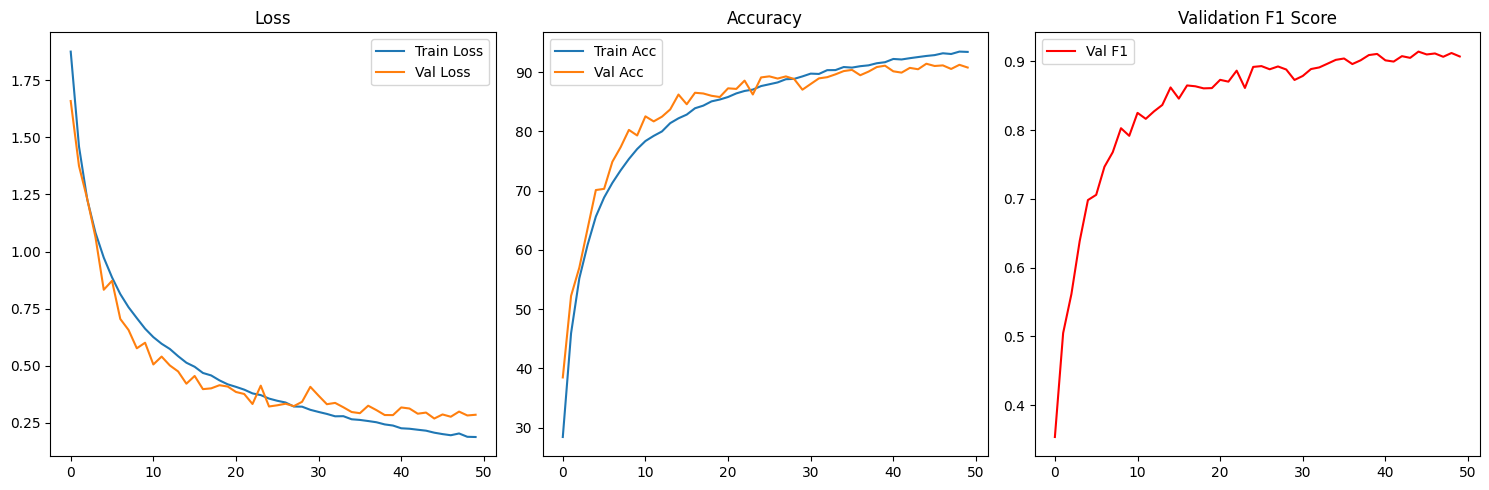

📈 Training plots saved as 'training_plots.png'


In [14]:
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

# Simple metrics tracking
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'val_precision': [], 'val_recall': [], 'val_f1': []
}

best_val_acc = 0
best_model_path = "best_model.pth"

for epoch in range(epochs):
    
    # ===== TRAINING =====
    net.train()
    train_loss, train_correct = 0, 0
    all_train_preds, all_train_labels = [], []
    
    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]'):
        images, labels = batch["img"].to(device), batch["label"].to(device)
        
        # Forward + Backward
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Stats
        train_loss += loss.item() * images.size(0)
        preds = outputs.argmax(1)
        train_correct += (preds == labels).sum().item()
        
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())
    
    # Training metrics
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = 100. * train_correct / len(train_loader.dataset)
    
    # ===== VALIDATION =====
    net.eval()
    val_loss, val_correct = 0, 0
    all_val_preds, all_val_labels, all_val_probs = [], [], []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]'):
            images, labels = batch["img"].to(device), batch["label"].to(device)
            
            outputs = net(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            
            # Get probabilities for metrics
            probs = torch.softmax(outputs, dim=1)
            
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())
            all_val_probs.extend(probs.cpu().numpy())
    
    # Validation metrics
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = 100. * val_correct / len(val_loader.dataset)
    
    # ===== COMPUTE METRICS =====
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    val_precision = precision_score(all_val_labels, all_val_preds, average='macro', zero_division=0)
    val_recall = recall_score(all_val_labels, all_val_preds, average='macro', zero_division=0)
    val_f1 = f1_score(all_val_labels, all_val_preds, average='macro', zero_division=0)
    
    # ===== STORE HISTORY =====
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)
    
    # ===== PRINT RESULTS =====
    print(f"\n Epoch {epoch+1} Results:")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"   Val Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f}")
    print(f"   LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # ===== SAVE BEST MODEL =====
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(net.state_dict(), best_model_path)
        print(f"NEW BEST MODEL! Val Acc: {val_acc:.2f}%")
        
        # Save classification report for best model
        class_names = ['airplane', 'auto', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        report = classification_report(all_val_labels, all_val_preds, target_names=class_names, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        report_df.to_csv('best_model_classification_report.csv')
        
        # Save confusion matrix
        cm = confusion_matrix(all_val_labels, all_val_preds)
        np.savetxt('best_model_confusion_matrix.csv', cm, delimiter=',', fmt='%d')
    
    # ===== LEARNING RATE SCHEDULING =====
    lr_scheduler.step(val_loss)

print(f"\n Training Complete! Best Val Acc: {best_val_acc:.2f}%")

history_df = pd.DataFrame(history)
history_df.to_csv('training_history.csv', index=False)
print("Training history saved to 'training_history.csv'")

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

# Plot F1 Score
plt.subplot(1, 3, 3)
plt.plot(history['val_f1'], label='Val F1', color='red')
plt.title('Validation F1 Score')
plt.legend()

plt.tight_layout()
plt.savefig('training_plots.png', dpi=100, bbox_inches='tight')
plt.show()

print("Training plots saved as 'training_plots.png'")

Generating final predictions:   0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Generating final predictions: 100%|██████████| 79/79 [00:03<00:00, 21.01it/s]


CUSTOM CNN - CLASSIFICATION REPORT
              precision    recall  f1-score   support

    airplane     0.8849    0.9460    0.9145      1000
  automobile     0.9775    0.9560    0.9666      1000
        bird     0.8768    0.8970    0.8868      1000
         cat     0.8519    0.7940    0.8219      1000
        deer     0.8983    0.9270    0.9124      1000
         dog     0.8277    0.8890    0.8573      1000
        frog     0.9477    0.9250    0.9362      1000
       horse     0.9626    0.9000    0.9302      1000
        ship     0.9753    0.9470    0.9609      1000
       truck     0.9505    0.9600    0.9552      1000

    accuracy                         0.9141     10000
   macro avg     0.9153    0.9141    0.9142     10000
weighted avg     0.9153    0.9141    0.9142     10000


Detailed classification report saved to: 'custom_cnn_detailed_classification_report.csv'

Overall Accuracy: 0.9141 (91.41%)

PER-CLASS ACCURACY
airplane    : 0.9460 (94.60%)
automobile  : 0.9560 (95.60%)
b

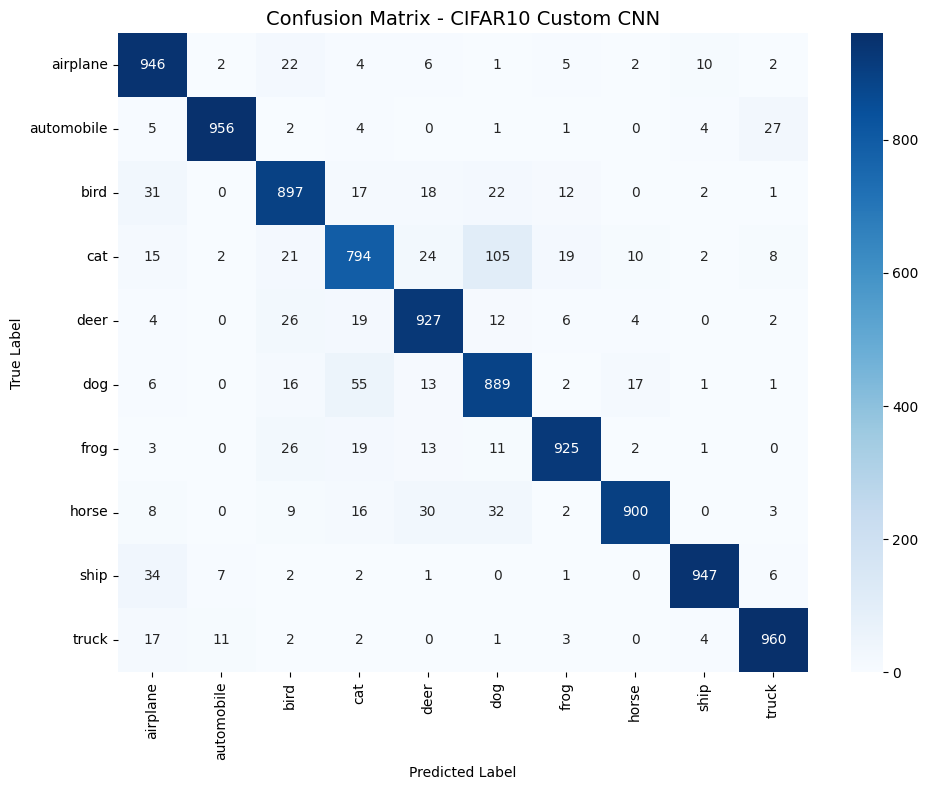

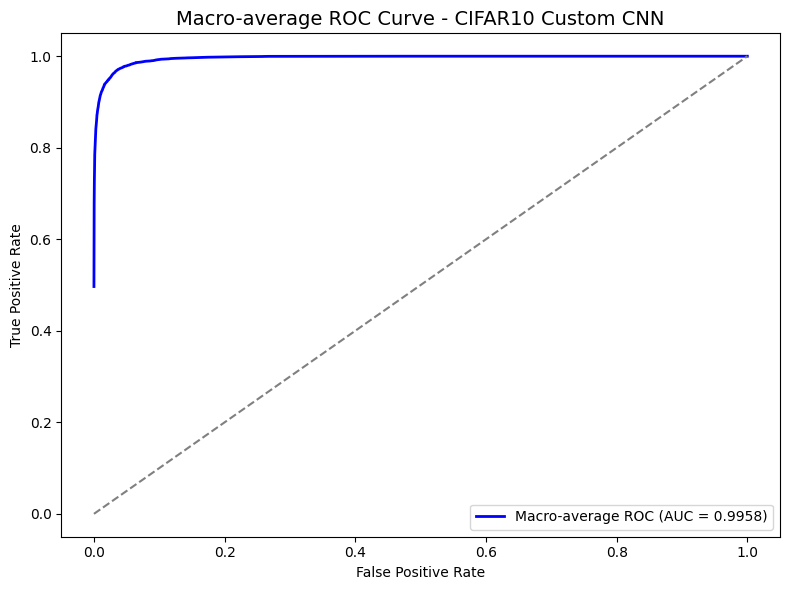

In [21]:
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_curve,
    auc
)

net.load_state_dict(torch.load(best_model_path))
net.eval()

all_val_preds = []
all_val_labels = []
all_val_probs = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc='Generating final predictions'):
        images, labels = batch["img"].to(device), batch["label"].to(device)
        outputs = net(images)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(1)

        all_val_preds.extend(preds.cpu().numpy())
        all_val_labels.extend(labels.cpu().numpy())
        all_val_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
all_val_preds = np.array(all_val_preds)
all_val_labels = np.array(all_val_labels)
all_val_probs = np.array(all_val_probs)

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# -----------------------------------------------------------------------------
# Classification Report
# -----------------------------------------------------------------------------
print("=" * 80)
print("CUSTOM CNN - CLASSIFICATION REPORT")
print("=" * 80)

report = classification_report(all_val_labels, all_val_preds, target_names=class_names, digits=4)
print(report)

# Save detailed classification report to CSV
report_dict = classification_report(all_val_labels, all_val_preds, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv('custom_cnn_detailed_classification_report.csv', index=True)
print(f"\nDetailed classification report saved to: 'custom_cnn_detailed_classification_report.csv'")

# -----------------------------------------------------------------------------
# Accuracy Metrics
# -----------------------------------------------------------------------------
accuracy = accuracy_score(all_val_labels, all_val_preds)
print(f"\nOverall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

cm = confusion_matrix(all_val_labels, all_val_preds)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

print("\n" + "=" * 50)
print("PER-CLASS ACCURACY")
print("=" * 50)
for i, class_name in enumerate(class_names):
    print(f"{class_name:12}: {class_accuracy[i]:.4f} ({class_accuracy[i]*100:.2f}%)")

# -----------------------------------------------------------------------------
# Confusion Matrix Heatmap
# -----------------------------------------------------------------------------
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - CIFAR10 Custom CNN", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix_heatmap.png", dpi=300)
plt.show()

# -----------------------------------------------------------------------------
# Macro ROC-AUC Curve
# -----------------------------------------------------------------------------
# Binarize labels for ROC computation
y_true_bin = label_binarize(all_val_labels, classes=list(range(len(class_names))))
n_classes = y_true_bin.shape[1]

# Compute macro-average ROC
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_val_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Average across all classes
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

macro_auc = auc(all_fpr, mean_tpr)

# Plot macro ROC-AUC curve
plt.figure(figsize=(8, 6))
plt.plot(all_fpr, mean_tpr, color='blue', lw=2,
         label=f'Macro-average ROC (AUC = {macro_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("Macro-average ROC Curve - CIFAR10 Custom CNN", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("macro_roc_auc_curve.png", dpi=300)
plt.show()

Evaluating on test set:   0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Evaluating on test set: 100%|██████████| 79/79 [00:03<00:00, 21.57it/s]


CUSTOM CNN - TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

    airplane     0.9479    0.9862    0.9667      1014
  automobile     0.9931    0.9892    0.9911      1014
        bird     0.9483    0.9643    0.9563       952
         cat     0.9374    0.9134    0.9252      1016
        deer     0.9680    0.9719    0.9700       997
         dog     0.9258    0.9493    0.9374      1025
        frog     0.9815    0.9745    0.9780       980
       horse     0.9905    0.9580    0.9740       977
        ship     0.9959    0.9751    0.9854      1003
       truck     0.9883    0.9912    0.9897      1022

    accuracy                         0.9673     10000
   macro avg     0.9677    0.9673    0.9674     10000
weighted avg     0.9676    0.9673    0.9673     10000


Overall Test Accuracy: 0.9673 (96.73%)


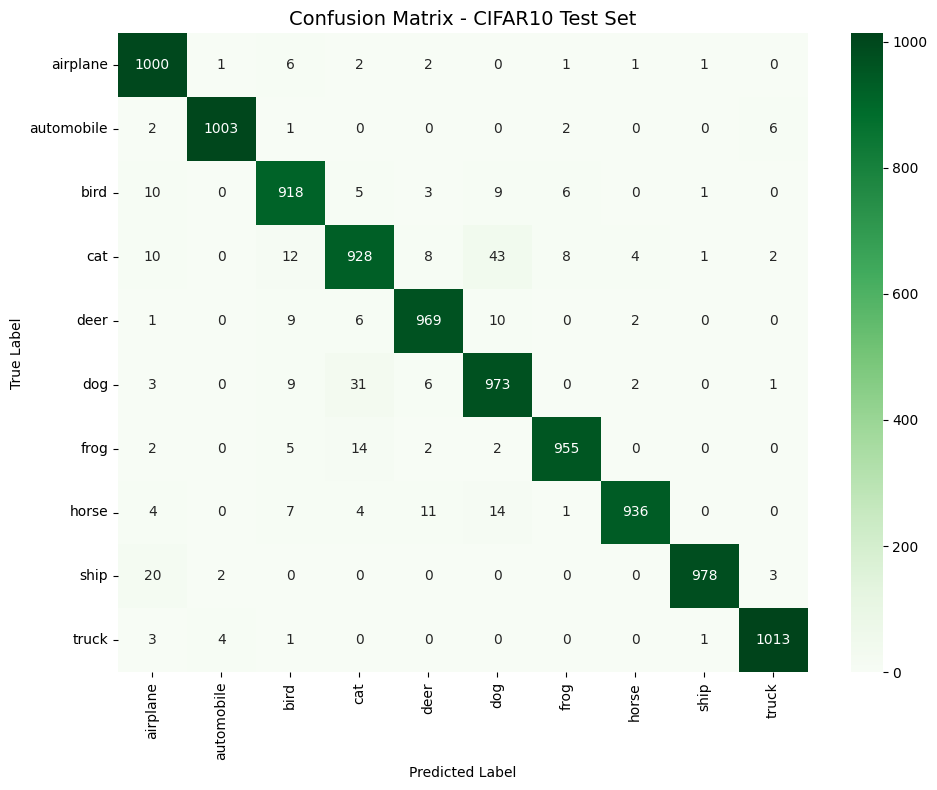


Test set evaluation complete.


In [23]:
test_label = np.array(test_label)

net.eval()
all_test_preds = []
all_test_probs = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating on test set"):
        images = batch["img"].to(device)
        outputs = net(images)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(1)

        all_test_preds.extend(preds.cpu().numpy())
        all_test_probs.extend(probs.cpu().numpy())

all_test_preds = np.array(all_test_preds)
all_test_probs = np.array(all_test_probs)

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']


print("=" * 80)
print("CUSTOM CNN - TEST SET CLASSIFICATION REPORT")
print("=" * 80)

report = classification_report(test_label, all_test_preds, target_names=class_names, digits=4)
print(report)

# --- Overall Accuracy ---
accuracy = accuracy_score(test_label, all_test_preds)
print(f"\nOverall Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# --- Confusion Matrix ---
cm = confusion_matrix(test_label, all_test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", 
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - CIFAR10 Test Set", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix_testset.png", dpi=300)
plt.show()

print("\nTest set evaluation complete.")